# RetailVista - Sales Prediction Model Training

This notebook trains an XGBoost model to predict **Item_Outlet_Sales** based on product and outlet features.

**Target Variable:** Item_Outlet_Sales (actual sales amount)

**Features:** Item characteristics (weight, fat content, visibility, type, MRP) and outlet characteristics (establishment year, size, location type, outlet type)

**Excluded:** ID columns (Item_Identifier, Outlet_Identifier), target variable from features, and derived metrics (Profit)

In [1]:
# Import libraries
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import joblib
import warnings
warnings.filterwarnings('ignore')

# Add parent directory to path to import preprocess module
sys.path.append('..')
from preprocess import create_preprocessor, get_feature_columns, prepare_features

In [2]:
# Load data
df = pd.read_csv('../data/supermarket_sales.csv')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (8523, 13)


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Profit
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8,OUT049,1999,Medium,Tier 2,Supermarket Type1,3735.1380,11.5
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.3,OUT018,2009,Medium,Tier 2,Supermarket Type2,443.4228,14.3
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6,OUT049,1999,Medium,Tier 2,Supermarket Type1,2097.2700,14.5
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.1,OUT010,1998,Medium,Tier 2,Grocery Store,732.3800,13.6
4,NCD19,8.93,Low Fat,0.000000,Household,53.9,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,14.1


In [3]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())
print(f"\nTotal missing values: {df.isnull().sum().sum()}")

Missing values per column:
Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
Profit                       0
dtype: int64

Total missing values: 0


In [4]:
# Dataset info
print("Dataset columns and types:")
print(df.dtypes)
print(f"\nDataset size: {len(df)} rows")

Dataset columns and types:
Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
Profit                       float64
dtype: object

Dataset size: 8523 rows


## Data Preparation

We'll use the shared preprocessing module to ensure consistency between training and inference.

In [5]:
# Get feature columns from preprocessing module
numeric_features, categorical_features = get_feature_columns()
print("Numeric features:", numeric_features)
print("\nCategorical features:", categorical_features)

Numeric features: ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']

Categorical features: ['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']


In [6]:
# Prepare features and target
X = prepare_features(df)
y = df['Item_Outlet_Sales']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget statistics:")
print(y.describe())

Features shape: (8523, 9)
Target shape: (8523,)

Target statistics:
count     8523.000000
mean      2181.288914
std       1706.499616
min         33.290000
25%        834.247400
50%       1794.331000
75%       3101.296400
max      13086.964800
Name: Item_Outlet_Sales, dtype: float64


In [7]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 6818
Test set size: 1705


## Preprocessing Pipeline

Create and fit the preprocessing pipeline on training data.

In [8]:
# Create preprocessor
preprocessor = create_preprocessor()

# Fit and transform training data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Processed training data shape: {X_train_processed.shape}")
print(f"Processed test data shape: {X_test_processed.shape}")

Processed training data shape: (6818, 35)
Processed test data shape: (1705, 35)


## Model Training

Train an XGBoost Regressor with fixed random state for reproducibility.

In [9]:
# Train XGBoost model
model = XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

print("Training model...")
model.fit(X_train_processed, y_train)
print("Training complete!")

Training model...
Training complete!


## Model Evaluation

In [10]:
# Make predictions
y_train_pred = model.predict(X_train_processed)
y_test_pred = model.predict(X_test_processed)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("=" * 50)
print("MODEL EVALUATION METRICS")
print("=" * 50)
print("\nTraining Set:")
print(f"  RMSE: {train_rmse:.2f}")
print(f"  MAE:  {train_mae:.2f}")
print(f"  R²:   {train_r2:.4f}")
print("\nTest Set:")
print(f"  RMSE: {test_rmse:.2f}")
print(f"  MAE:  {test_mae:.2f}")
print(f"  R²:   {test_r2:.4f}")
print("=" * 50)

MODEL EVALUATION METRICS

Training Set:
  RMSE: 958.13
  MAE:  681.81
  R²:   0.6897

Test Set:
  RMSE: 1047.60
  MAE:  729.87
  R²:   0.5962


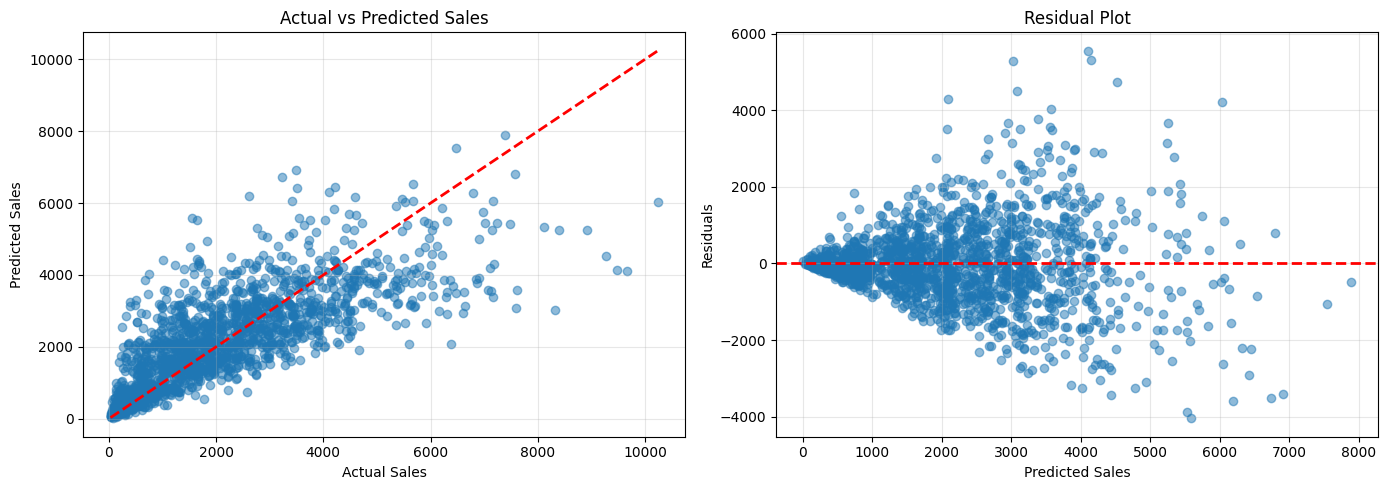

In [11]:
# Visualize predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Actual vs Predicted
axes[0].scatter(y_test, y_test_pred, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Sales')
axes[0].set_ylabel('Predicted Sales')
axes[0].set_title('Actual vs Predicted Sales')
axes[0].grid(True, alpha=0.3)

# Residuals
residuals = y_test - y_test_pred
axes[1].scatter(y_test_pred, residuals, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Sales')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Top 10 Most Important Features:
                            feature  importance
31        Outlet_Type_Grocery Store    0.562772
2                          Item_MRP    0.110434
3         Outlet_Establishment_Year    0.073880
16            Item_Type_Hard Drinks    0.025975
13                  Item_Type_Dairy    0.012765
26               Outlet_Size_Medium    0.012595
24          Item_Type_Starchy Foods    0.012458
18              Item_Type_Household    0.011940
5          Item_Fat_Content_Low Fat    0.011550
15  Item_Type_Fruits and Vegetables    0.011521


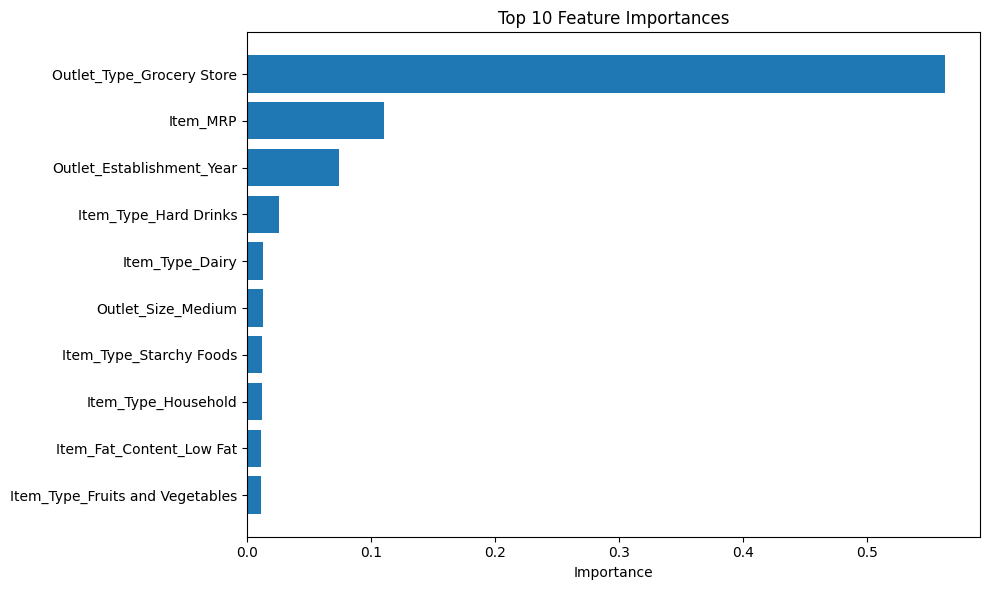

In [12]:
# Feature importance
feature_names = numeric_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance.head(10)['feature'], feature_importance.head(10)['importance'])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Save Model and Preprocessor

In [13]:
# Save model
joblib.dump(model, '../model/model.pkl')
print("Model saved to: ../model/model.pkl")

# Save preprocessor
joblib.dump(preprocessor, '../model/preprocessor.pkl')
print("Preprocessor saved to: ../model/preprocessor.pkl")

# Save metrics for reference
metrics = {
    'test_rmse': test_rmse,
    'test_mae': test_mae,
    'test_r2': test_r2,
    'train_rmse': train_rmse,
    'train_mae': train_mae,
    'train_r2': train_r2
}
joblib.dump(metrics, '../model/metrics.pkl')
print("Metrics saved to: ../model/metrics.pkl")

Model saved to: ../model/model.pkl
Preprocessor saved to: ../model/preprocessor.pkl
Metrics saved to: ../model/metrics.pkl


## Summary

**Model:** XGBoost Regressor

**Target:** Item_Outlet_Sales

**Features:** 8 features (4 numeric + 4 categorical)

**Data Leakage:** None - ID columns and target variable properly excluded

**Preprocessing:** Consistent pipeline using StandardScaler and OneHotEncoder

**Evaluation:** Train/test split with RMSE, MAE, and R² metrics reported